In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import skimage.io as io
import skimage.color
import cv2
import json
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as tvt
import time
import torchvision
import glob
from matplotlib.patches import Rectangle 
import random
import torchvision.ops as ops



/local/scratch/a/oachary/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 121
torch.manual_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
# Load COCO dataset
train_annotation_path = '/local/scratch/a/oachary/Classes/Semester2/ECE60146/Datasets/Coco/annotations/instances_train2017.json' #location of train annotation
coco_train = COCO(train_annotation_path)


def get_category_id(category_name):
    cat_ids = coco_train.getCatIds(catNms=[category_name])
    if cat_ids:
        return cat_ids[0]
    else:
        return None

# Categories of interest
categories_of_interest = ['cake', 'dog', 'motorcycle'] #list of categories by name
category_ids_of_interest= [get_category_id(category) for category in categories_of_interest]
category_id_to_class_map= {key:value for (key, value) in zip(category_ids_of_interest, categories_of_interest) }
category_id_to_classid_map= {key:value for (key, value) in zip(category_ids_of_interest, [0, 1, 2]) }


# Load annotations
train_annotation_dir = '/local/scratch/a/oachary/Classes/Semester2/ECE60146/Datasets/Extracted_CocoLOAD/train'
test_annotation_dir = '/local/scratch/a/oachary/Classes/Semester2/ECE60146/Datasets/Extracted_CocoLOAD/validation'

# Function to load annotations
def load_annotations(annotation_dir):
    annotations = []
    for file in os.listdir(annotation_dir):
        if file.endswith('.json'):
            with open(os.path.join(annotation_dir, file), 'r') as f:
                annotations.append(json.load(f))
    return annotations

# Load training annotations
train_annotations = load_annotations(train_annotation_dir)

# Load testing annotations
test_annotations = load_annotations(test_annotation_dir)


loading annotations into memory...
Done (t=16.50s)
creating index...
index created!


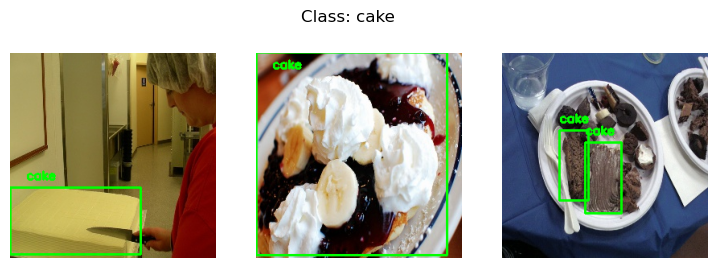

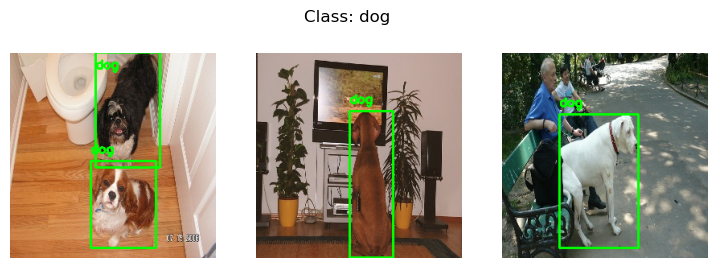

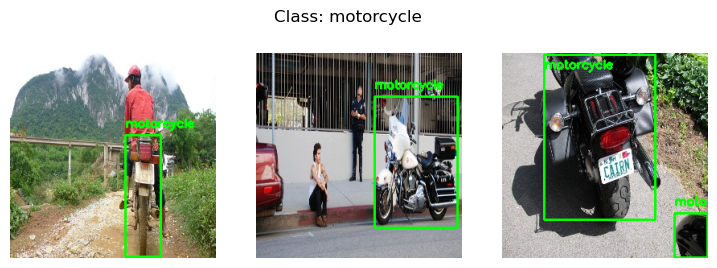

In [4]:
# Function to display images with bounding boxes for multiple objects
def display_images_with_multiple_bounding_boxes(annotations, category, id, max_images=3):
    fig, axes = plt.subplots(1, max_images, figsize=(9, 3))
    printed_image_names = set()  # Track printed image names to avoid duplicates
    fig.suptitle(f"Class: {category}")
    image_count = 0
    for annotation in annotations:
        if id in annotation['category_ids']:
            image_name = annotation['image_name']
            if image_name not in printed_image_names:
                image_path = os.path.join(train_annotation_dir, image_name)
                image = cv2.imread(image_path)
                printed_image_names.add(image_name)
                for idx, bbox in enumerate(annotation['bboxes']):
                    x, y, w, h = bbox
                    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    #to find the right place to place the text
                    a= min(x,256-20) if x>128 else max(x, 20)
                    b= min(y-10,256-20) if y-10>128 else max(y-10, 20)


                    cv2.putText(image, annotation['class_names'][idx], (a, b), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 256, 0), 2)
                    # cv2.rectangle(image, (1, 1), (100, 100), (0, 255, 0), 2)
                axes[image_count].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                axes[image_count].axis('off')
                image_count += 1
                if image_count >= max_images:
                    break
    plt.show()

# Display images with multiple bounding boxes for each class
for (category, id) in zip(categories_of_interest, category_ids_of_interest):
    display_images_with_multiple_bounding_boxes(train_annotations, category, id)


In [5]:
print(categories_of_interest, category_ids_of_interest)

['cake', 'dog', 'motorcycle'] [61, 18, 4]


In [6]:
import os
import json
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CocoLOADDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
        self.annotations = self.load_annotations()

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, self.annotations[idx]['image_name'])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        bboxes_tensor= torch.zeros(15, 4, dtype=torch.uint8) #assuming there are maximum 15 objects
        # category_id_tensor= torch.zeros(15, dtype=torch.uint8)+15 #assuming there are maximum 15 objects
        class_id_tensor= torch.zeros(15, dtype=torch.uint8)+15 #assuming there are maximum 15 objects
        num_objects= self.annotations[idx]['num_objects']
        for i in range(len(self.annotations[idx]['bboxes'])):
            bboxes = self.annotations[idx]['bboxes'][i]
            # category_id = self.annotations[idx]['category_ids'][i]
            class_id= self.annotations[idx]['class_ids'][i]
            segmentation= self.annotations[idx]['segmentations'][i] # just keeping in case of future requirement
            bboxes_tensor[i]= torch.LongTensor(bboxes)
            # category_id_tensor[i]= category_id
            class_id_tensor[i]= class_id
            

       
        image = self.transform(image)

        return image, bboxes_tensor, class_id_tensor, num_objects

    def load_annotations(self):
        annotations = []
        for file in os.listdir(self.data_dir):
            if file.endswith('.json'):
                with open(os.path.join(self.data_dir, file), 'r') as f:
                    annotations.append(json.load(f))
        return annotations


# Define paths to the extracted images and annotations
train_data_dir = '/local/scratch/a/oachary/Classes/Semester2/ECE60146/Datasets/Extracted_CocoLOAD/train'
test_data_dir = '/local/scratch/a/oachary/Classes/Semester2/ECE60146/Datasets/Extracted_CocoLOAD/validation'

# Create custom datasets
train_dataset = CocoLOADDataset(train_data_dir)
test_dataset = CocoLOADDataset(test_data_dir)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)



In [7]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        out += residual
        out = self.relu(out)
        return out

class CustomLOAD(nn.Module):
    def __init__(self, in_channels=3, width=8, num_blocks=5):
        super(CustomLOAD, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels, width, kernel_size=7, padding=3),
            nn.BatchNorm2d(width),
            nn.ReLU(inplace=True),
            *[nn.Sequential(
                nn.Conv2d(width * 2**i, width * 2**(i+1), kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(width * 2**(i+1)),
                nn.ReLU(inplace=True)
            ) for i in range(4)],
            *[ResidualBlock(width * 2**4) for _ in range(num_blocks)]
        )

        self.classifier = nn.Sequential(
            nn.Linear(32768, 11520),
            nn.BatchNorm1d(11520),
            nn.ReLU(inplace=True),
            nn.Linear(11520, 2880)
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


In [8]:
class trainer():

    def __init__(self, train_dataloader, test_dataloader, epochs, lr, momentum, yolo_interval, class_labels, cIoU_for_regression=False):
        self.train_dataloader= train_dataloader
        self.test_dataloader= test_dataloader
        self.epochs= epochs
        self.learning_rate= lr
        self.momentum= momentum
        self.yolo_interval= yolo_interval
        self.class_labels= class_labels
        self.device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.cIou_for_regression= cIoU_for_regression
        # self.device= torch.device('cpu')

    def train(self, net, model_save_name, display_labels=False, display_images=False):         
            """Trains object detection and localization model using yolo logic. It is adapted from run_code_for_training_multi_instance_detection method
            in YOLOLogic (https://engineering.purdue.edu/kak/distYOLO/)"""
            yolo_debug = False
            filename_for_out1 = "performance_numbers_" + str(self.epochs) + "label.txt"                                
            filename_for_out2 = "performance_numbers_" + str(self.epochs) + "regres.txt"                               
            FILE1 = open(filename_for_out1, 'w')                                                                           
            FILE2 = open(filename_for_out2, 'w')                                                                           
            net = net.to(self.device) 

            if(model_save_name in os.listdir()):
                print('Loaded the saved model!')
                net.load_state_dict(torch.load('yolomodel.pth'))

            criterion1 = nn.BCELoss(reduction='sum')          # For the first element of the 8 element yolo vector                ## (1)
            criterion2 = nn.MSELoss(reduction='sum')          # For the regression elements (indexed 2,3,4,5) of yolo vector      ## (2)
            criterion3 = nn.CrossEntropyLoss(reduction='sum') # For the last three elements of the 8 element yolo vector          ## (3)
                                                              # Actually, the CrossEntropyLoss works on last four elements of
                                                              #   the augmented yolo vectors.  We add one more element to the 
                                                              #   8-element yolo vectors to allow for nilmapping.
            print("\n\nLearning Rate: ", self.learning_rate)
            optimizer = optim.SGD(net.parameters(), lr=self.learning_rate, momentum=self.momentum)                ## (4)
            print("\n\nStarting training loop...\n\n")
            start_time = time.perf_counter()
            Loss_tally = []
            bceloss_tally=[]
            regloss_tally=[]
            celoss_tally=[]
            elapsed_time = 0.0
            yolo_interval = self.yolo_interval                                                                            ## (5)
            num_yolo_cells = (256 // yolo_interval) * (256 // yolo_interval)        ## (6)
            num_anchor_boxes =  5    # (height/width)   1/5  1/3  1/1  3/1  5/1                                                   ## (7)
            max_obj_num  = 15                                                                                                      ## (8)
            for epoch in range(self.epochs):                                                                              ## (9)
                print("")
                running_loss = 0.0                                                                                        ## (86)
                running_bceloss = 0.0
                running_regressionloss = 0.0
                running_labelingloss = 0.0                                                                                               ## (10)
                for iter, data in enumerate(self.train_dataloader):   
                    if yolo_debug:
                        print("\n\n\n======================================= iteration: %d ========================================\n" % iter)
                    im_tensor, bbox_tensor, bbox_label_tensor, num_objects_in_image = data                       ## (11)
                    im_tensor   = im_tensor.to(self.device)                                 
                    # seg_mask_tensor = seg_mask_tensor.to(self.device)                 
                    bbox_tensor = bbox_tensor.to(self.device)
                    bbox_label_tensor = bbox_label_tensor.to(self.device)
                    ## The 8 in the following is the size of the yolo_vector for each anchor-box in a given cell.  The 8 elements 
                    ## are: [obj_present, bx, by, bh, bw, c1, c2, c3] where bx and by are the delta diffs between the centers
                    ## of the yolo cell and the center of the object bounding box in terms of a unit for the cell width and cell 
                    ## height.  bh and bw are the height and the width of object bounding box in terms of the cell height and 
                    ## width.
                    yolo_tensor = torch.zeros( im_tensor.shape[0], num_yolo_cells, num_anchor_boxes, 8 ).to(self.device)  ## (12)
                    ## We also define an augmented version of the above in which each yolo vector is augmented with one 
                    ## additional element so that its length is now equal to 9 elements.  The additional element is for what's
                    ## known as nil-mapping in computer vision.  What that means is that if we know there is no object present in
                    ## a given cell/anchor_box combo, then we need a place to park the probability mass for the class labels
                    ## for that combo. Speaking a bit more precisely, using CrossEntropy loss for the class labels means that
                    ## a Softmax activation (involving a probability based normalization of the computed values) would ordinarily 
                    ## be applied to the last 3 elements of the 8-element yolo vector.  However, that would make no sense for
                    ## the case when a given cell/anchor_box combo contains no objects.  Extending the yolo vector by one 
                    ## additional element allows for the probability mass to shift to that element when there is nothing in
                    ## combo. From the standpoint of learning, a value of 1 stored in that extra element becomes the target
                    ## for the CrossEntropy loss calculation applied to the bast FOUR elements of the yolo vectors in the 
                    ## following tensor:
                    yolo_tensor_aug = torch.zeros(im_tensor.shape[0], num_yolo_cells,num_anchor_boxes,9).to(self.device)  ## (13)
                    if yolo_debug:
                        logger = logging.getLogger()
                        old_level = logger.level
                        logger.setLevel(100)
                        plt.figure(figsize=[15,4])
                        plt.imshow(np.transpose(torchvision.utils.make_grid(im_tensor,normalize=True,padding=3,pad_value=255).cpu(), (1,2,0)))
                        plt.show()
                        logger.setLevel(old_level)
                    cell_height = yolo_interval                                                                                   ## (14)
                    cell_width = yolo_interval                                                                                    ## (15)
                    if yolo_debug:
                        print("\n\nnum_objects_in_image: ")
                        print(num_objects_in_image)
                    num_cells_image_width = 256 // yolo_interval                                           ## (16)
                    num_cells_image_height = 256 // yolo_interval                                          ## (17)
                    ## ibx is batch instance index
                    for ibx in range(im_tensor.shape[0]):                                                                         ## (18)
                        ## idx is for object index
                        num_of_objects =   (torch.sum(bbox_label_tensor[ibx] != 15).type(torch.uint8)).item()                     ## (19)
                        for idx in range(num_of_objects):                                                                         ## (20)
                            if yolo_debug:
                                print("\n\n               ================  object indexed %d ===============              \n\n" % idx)
                                ## Note that the bounding-box coordinates are in the (x,y) format, with x-positive going to
                                ## right and the y-positive going down. A bbox is specified by (x_min,y_min,x_max,y_max):
                                print("\n\nshape of bbox_tensor: ", bbox_tensor[ibx].shape)
                                print("\n\nbbox_tensor:")
                                print(bbox_tensor[ibx])
                            ##  Since we are at pixel resolution at this point, there's not a whole lot of
                            ##  between floating point division and integer division:
                            height_center_bb =  (bbox_tensor[ibx,idx,1] + bbox_tensor[ibx,idx,3]) / 2.0                           ## (21)
                            width_center_bb =  (bbox_tensor[ibx,idx,0] + bbox_tensor[ibx,idx,2]) / 2.0                            ## (22)
                            obj_bb_height = bbox_tensor[ibx,idx,3] -  bbox_tensor[ibx,idx,1]                                      ## (23)
                            obj_bb_width = bbox_tensor[ibx,idx,2] - bbox_tensor[ibx,idx,0]                                        ## (24)
                            cell_row_indx =  (height_center_bb / yolo_interval).int()          ## for the i coordinate            ## (25)
                            cell_col_indx =  (width_center_bb / yolo_interval).int()           ## for the j coordinates           ## (26)
                            cell_row_indx = torch.clamp(cell_row_indx, max=num_cells_image_height - 1)                            ## (27)
                            cell_col_indx = torch.clamp(cell_col_indx, max=num_cells_image_width - 1)                             ## (28)
                            ## The bh and bw elements in the yolo vector for this object:  bh and bw are measured relative 
                            ## to the size of the grid cell to which the object is assigned.  For example, bh is the 
                            ## height of the bounding-box divided by the actual height of the grid cell.
                            bh  =  obj_bb_height.float() / yolo_interval                                                          ## (29)
                            bw  =  obj_bb_width.float()  / yolo_interval                                                          ## (30)
                            ## You have to be CAREFUL about object center calculation since bounding-box coordinates
                            ## are in (x,y) format --- with x-positive going to the right and y-positive going down.
                            obj_center_x =  (bbox_tensor[ibx,idx][2].float() +  bbox_tensor[ibx,idx][0].float()) / 2.0            ## (31)
                            obj_center_y =  (bbox_tensor[ibx,idx][3].float() +  bbox_tensor[ibx,idx][1].float()) / 2.0            ## (32)
                            ## Now you need to switch back from (x,y) format to (i,j) format:
                            yolocell_center_i =  cell_row_indx*yolo_interval + float(yolo_interval) / 2.0                         ## (33)
                            yolocell_center_j =  cell_col_indx*yolo_interval + float(yolo_interval) / 2.0                         ## (34)
                            del_x  =  (obj_center_x.float() - yolocell_center_j.float()) / yolo_interval                          ## (35)
                            del_y  =  (obj_center_y.float() - yolocell_center_i.float()) / yolo_interval                          ## (36)
                            class_label_of_object = bbox_label_tensor[ibx,idx].item()                                             ## (37)
                            AR = obj_bb_height.float() / obj_bb_width.float()                                                     ## (38)
                            if torch.isnan(AR):                                                                                   ## (39)
                                AR = 100.0                                                                                        ## (40)
                            else:
                                AR = AR.item()                                                                                    ## (41)
                            if AR <= 0.2:                                                                                         ## (42)
                                anch_box_index = 0                                                                                ## (43)
                            elif 0.2 < AR <= 0.5:                                                                                 ## (44)
                                anch_box_index = 1                                                                                ## (45)
                            elif 0.5 < AR <= 1.5:                                                                                 ## (46)
                                anch_box_index = 2                                                                                ## (47)
                            elif 1.5 < AR <= 4.0:                                                                                 ## (48)
                                anch_box_index = 3                                                                                ## (49)
                            elif AR > 4.0:                                                                                        ## (50)
                                anch_box_index = 4                                                                                ## (51)
                            yolo_vector = torch.FloatTensor([0,del_x, del_y, bh, bw, 0, 0, 0] ).to(self.device)           ## (52)
                            if class_label_of_object != 15:                                                                       ## (53)
                                yolo_vector[0] = 1.0                                                                              ## (54)
                                yolo_vector[5 + class_label_of_object] = 1                                                        ## (55)
                            yolo_cell_index =  (cell_row_indx * num_cells_image_width  +  cell_col_indx).type(torch.uint8)        ## (56)
                            yolo_cell_index = yolo_cell_index.item()                                                              ## (57)
                            yolo_tensor[ibx, yolo_cell_index, anch_box_index] = yolo_vector                                       ## (58)
                            yolo_tensor_aug[ibx, yolo_cell_index, anch_box_index,:-1] = yolo_vector                               ## (59)
                    ##  The following loop plays a critical role in the overall logic of learning. The network needs
                    ##  to know that if the first element of a yolo vector is 0, meaning that there is no object present
                    ##  in that cell/anchor_box combo, then all the probability weight in the last four elements of the
                    ##  augmented yolo vector shifts to the last of the four elements:
                    for ibx in range(im_tensor.shape[0]):                                                                         ## (60)
                        for icx in range(num_yolo_cells):                                                                         ## (61)
                            for iax in range(num_anchor_boxes):                                                                   ## (62)
                                if yolo_tensor_aug[ibx, icx, iax, 0] == 0:                                                        ## (63)
                                    yolo_tensor_aug[ibx, icx, iax,-1] = 1                                                         ## (64)
                    optimizer.zero_grad()                                                                                         ## (65)
                    output = net(im_tensor)                                                                                       ## (66)
                    # print(output.shape)
                    predictions_aug = output.view(-1,num_yolo_cells,num_anchor_boxes,9)  
                    # print(predictions_aug.shape)                                         ## (67)

                    assert(yolo_tensor_aug[ibx,icx,iax,0]==0 or yolo_tensor_aug[ibx,icx,iax,0]==1) #to make sure it is either 0 or 1

                    ##  Now that we have the output of the network, must calculate the loss.  We initialize the loss tensors
                    ##  for this iteration of training:
                    loss = torch.tensor(0.0, requires_grad=True).float().to(self.device)
                    bce_loss= torch.tensor(0.0, requires_grad=False)
                    reg_loss= torch.tensor(0.0, requires_grad=False)
                    ce_loss= torch.tensor(0.0, requires_grad=False)                                  ## (68)
                    ##  Estimating presence/absence of object with the Binary Cross Entropy loss:
                    a= nn.Sigmoid()(predictions_aug[:,:,:,0])
                    a= torch.clamp(a,0.1,0.9)
                    # print(torch.min(a), torch.max(a))
                    # assert torch.logical_and(a >= 0, a <= 1).all()
                    # bceloss = criterion1( nn.Sigmoid()(predictions_aug[:,:,:,0]), yolo_tensor_aug[:,:,:,0] )  
                    bceloss = criterion1(a, yolo_tensor_aug[:,:,:,0] )  
                    bce_loss= bce_loss+ bceloss                 ## (69)
                    loss = loss + bceloss                                                                                               ## (70)
                    ## MSE loss for the regression params for the object bounding boxes:


                    if self.cIou_for_regression: #to use cIoU
                        # converting the values in predicted augmented vector in (x1, y1) and (x2, y2) format suitable for complete_box_iou_loss function:
                        pred_regression_vec = predictions_aug[:, :, :, 1:5]
                        pred_regression_vec_modified = pred_regression_vec.clone() #place holder for new format bbox values

                        gt_regression_vec= yolo_tensor_aug[:, :, :, 1:5]
                        gt_regression_vec_modified= gt_regression_vec.clone() #place holder for new format bbox values
                        gt_regression_list=[]
                        pred_regression_list=[]
                        num=0
                        #look through all the anchor boxes and get the values in the proper format 
                        for ibx in range(im_tensor.shape[0]):                                                                         ## (60)
                            for icx in range(num_yolo_cells):                                                                         ## (61)
                                for iax in range(num_anchor_boxes):                                                                   ## (62)
                                    if (predictions_aug[ibx, icx, iax, 0] and yolo_tensor_aug[ibx, icx, iax, 0]):

                                        del_x1, del_y1 = pred_regression_vec[ibx, icx, iax, 0], pred_regression_vec[ibx, icx, iax, 1]
                                        h1, w1 = pred_regression_vec[ibx, icx, iax, 2], pred_regression_vec[ibx, icx, iax, 3]
                                        h1 = max(0.001, h1* yolo_interval) #so that height and width values are not negative
                                        w1 = max(0.001, w1* yolo_interval) # and to make sure that x2 and y2 are larger than x1 and y1
                                        cell_row_index = icx // 8
                                        cell_col_index = icx % 8
                                        
                                        bb_center_x1 = cell_col_index * yolo_interval + yolo_interval / 2 + del_x1 * yolo_interval
                                        bb_center_y1 = cell_row_index * yolo_interval + yolo_interval / 2 + del_y1 * yolo_interval
                                        
                                        bb_top_left_x1 = (bb_center_x1 - w1 / 2.0).to(torch.int)
                                        bb_top_left_y1 = (bb_center_y1 - h1 / 2.0).to(torch.int)
                                        bb_bottom_right_x1 = bb_top_left_x1 + w1
                                        bb_bottom_right_y1 = bb_top_left_y1 + h1
                                        
                                        coordinates1= torch.tensor([bb_top_left_x1, bb_top_left_y1, bb_bottom_right_x1, bb_bottom_right_y1])
                                        gt_regression_list.append(coordinates1)
                                        
                                        pred_regression_vec_modified[ibx, icx, iax, 0] = bb_top_left_x1
                                        pred_regression_vec_modified[ibx, icx, iax, 1] = bb_top_left_y1
                                        pred_regression_vec_modified[ibx, icx, iax, 2] = bb_bottom_right_x1
                                        pred_regression_vec_modified[ibx, icx, iax, 3] = bb_bottom_right_y1

                                        del_x2, del_y2 = gt_regression_vec[ibx, icx, iax, 0], gt_regression_vec[ibx, icx, iax, 1]
                                        h2, w2 = gt_regression_vec[ibx, icx, iax, 2], gt_regression_vec[ibx, icx, iax, 3]
                                        h2 = max(0.001, h2* yolo_interval)
                                        w2 = max(0.001, w2* yolo_interval)
                                    
                                        bb_center_x2 = cell_col_index * yolo_interval + yolo_interval / 2 + del_x2 * yolo_interval
                                        bb_center_y2 = cell_row_index * yolo_interval + yolo_interval / 2 + del_y2 * yolo_interval
                                        
                                        bb_top_left_x2 = (bb_center_x2 - w2 / 2.0).to(torch.int)
                                        bb_top_left_y2 = (bb_center_y2 - h2 / 2.0).to(torch.int)
                                        bb_bottom_right_x2 = bb_top_left_x2 + w2
                                        bb_bottom_right_y2 = bb_top_left_y2 + h2
                                        
                                        coordinates2= torch.tensor([bb_top_left_x2, bb_top_left_y2, bb_bottom_right_x2, bb_bottom_right_y2])
                                        pred_regression_list.append(coordinates2)
                                    
                                        gt_regression_vec_modified[ibx, icx, iax, 0] = bb_top_left_x2
                                        gt_regression_vec_modified[ibx, icx, iax, 1] = bb_top_left_y2
                                        gt_regression_vec_modified[ibx, icx, iax, 2] = bb_bottom_right_x2
                                        gt_regression_vec_modified[ibx, icx, iax, 3] = bb_bottom_right_y2
                                                
                        
                        # print(gt_regression_list)
                        gt_regression_tensor= torch.stack(gt_regression_list).to(self.device)
                        pred_regression_tensor= torch.stack(pred_regression_list).to(self.device)
                    
                        pred_regression_vec_reshaped = pred_regression_tensor.view(-1, 4)
                        gt_regression_vec_reshaped= gt_regression_tensor.view(-1, 4)
                        
                        regression_loss = ops.complete_box_iou_loss(pred_regression_vec_reshaped, gt_regression_vec_reshaped, reduction='sum')

                    else:
                        regression_loss = criterion2(predictions_aug[:,:,:,1:5], yolo_tensor_aug[:,:,:,1:5])  
                    reg_loss= reg_loss+ regression_loss                        ## (71)
                    loss = loss+ regression_loss                                                                                       ## (72)
                    ##  CrossEntropy loss for object class labels:
                    targets = yolo_tensor_aug[:,:,:,5:]                                                                           ## (73)
                    targets = targets.view(-1,4)                                                                                  ## (74)
                    targets = torch.argmax(targets, dim=1)                                                                        ## (75)
                    probs = predictions_aug[:,:,:,5:]                                                                             ## (76)
                    probs = probs.view(-1,4)                                                                                      ## (77)
                    class_labeling_loss = criterion3( probs, targets)                                                             ## (78)
                    ce_loss= ce_loss+ class_labeling_loss
                    loss = loss+  class_labeling_loss                                                                                  ## (79)
                    if yolo_debug:
                        print("\n\nshape of loss: ", loss.shape)
                        print("\n\nloss: ", loss)
                    loss.backward()                                                                                               ## (80)
                    optimizer.step()                                                                                              ## (81)
                    running_loss = running_loss+ loss.item()  
                    running_bceloss= running_bceloss+ bce_loss.item()
                    running_labelingloss= running_labelingloss+ ce_loss.item()
                    running_regressionloss= running_regressionloss+ reg_loss.item()                                                                                 ## (82)
                    if iter%50==49:                                                                                             ## (83)
                        current_time = time.perf_counter()                                                                    
                        elapsed_time = current_time - start_time 
                        avg_loss = running_loss / float(50)                                                                      ## (84)
                        print("\n[epoch:%d/%d, iter=%4d  elapsed_time=%5d secs]      mean value for loss: %7.4f" % 
                                                            (epoch+1,self.epochs, iter+1, elapsed_time, avg_loss))        ## (85)
                        Loss_tally.append(running_loss)
                        bceloss_tally.append(running_bceloss)
                        celoss_tally.append(running_labelingloss)
                        regloss_tally.append(running_regressionloss)
                        FILE1.write("%.3f\n" % avg_loss)
                        FILE1.flush()
                        running_loss = 0.0                                                                                        ## (86)
                        running_bceloss = 0.0
                        running_regressionloss = 0.0
                        running_labelingloss = 0.0
                        if display_labels:
                            for ibx in range(predictions_aug.shape[0]):                             # for each batch image        
                                icx_2_best_anchor_box = {ic : None for ic in range(36)}                                           ## (88)
                                for icx in range(predictions_aug.shape[1]):                         # for each yolo cell          ## (89)
                                    cell_predi = predictions_aug[ibx,icx]                                                         ## (90)
                                    prev_best = 0                                                                                 ## (91)
                                    for anchor_bdx in range(cell_predi.shape[0]):                                                 ## (92)
                                        if cell_predi[anchor_bdx][0] > cell_predi[prev_best][0]:                                  ## (93)
                                            prev_best = anchor_bdx                                                                ## (94)
                                    best_anchor_box_icx = prev_best                                                               ## (95)
                                    icx_2_best_anchor_box[icx] = best_anchor_box_icx   #assign best anchor box to each cell in the image                                           
                                sorted_icx_to_box = sorted(icx_2_best_anchor_box,                                                 ## (97)
                                      key=lambda x: predictions_aug[ibx,x,icx_2_best_anchor_box[x]][0].item(), reverse=True)      ## (98)
                                retained_cells = sorted_icx_to_box[:15]   #retain the best 15 cells                                                         
                                objects_detected = []                                                                             ## (100)
                                for icx in retained_cells:                                                                        ## (101)
                                    pred_vec = predictions_aug[ibx,icx, icx_2_best_anchor_box[icx]]                               ## (102)
                                    class_labels_predi  = pred_vec[-4:]                                                           ## (103)
                                    class_labels_probs = torch.nn.Softmax(dim=0)(class_labels_predi)                              ## (104)
                                    class_labels_probs = class_labels_probs[:-1]                                                  ## (105)
                                    if torch.all(class_labels_probs < 0.2):                                                      ## (115)
                                        predicted_class_label = None                                                              ## (116)
                                    else:                                                                                
                                        best_predicted_class_index = (class_labels_probs == class_labels_probs.max())             ## (117)
                                        best_predicted_class_index =torch.nonzero(best_predicted_class_index,as_tuple=True)       ## (118)
                                        predicted_class_label =self.class_labels[best_predicted_class_index[0].item()]    ## (119)
                                        objects_detected.append(predicted_class_label)                                            ## (120)

                                print("[batch image=%d]  objects found in descending probability order: " % ibx, 
                                                                                                     objects_detected)            ## (121)
                        if display_images:
        
                            plt.figure(figsize=[15,4])
                            plt.imshow(np.transpose(torchvision.utils.make_grid(im_tensor, normalize=True,
                                                                             padding=3, pad_value=255).cpu(), (1,2,0)))
                            plt.show()
                            
            print("\nFinished Training\n")
            plt.figure(figsize=(10,5))
            plt.title("Loss vs. Iterations")
            plt.plot(Loss_tally, label='Total Loss')
            plt.plot(bceloss_tally, label='BCE Loss')
            plt.plot(celoss_tally, label='Labeling Loss')
            plt.plot(regloss_tally, label='Regression Loss')
            plt.xlabel("iterations")
            plt.ylabel("Loss")
            plt.legend()
            plt.savefig("training_loss.png")
            plt.show()
            torch.save(net.state_dict(), model_save_name)
            print(f'Model saved at {model_save_name}')
            return Loss_tally
    

    def test(self, net, dir_name_for_results, saved_model_name, display_images=True):  
            """Evaluates object detection and localization model using yolo logic. It is adapted from run_code_for_testing_multi_instance_detection method
            in YOLOLogic (https://engineering.purdue.edu/kak/distYOLO/)"""
            yolo_debug = False
            net.load_state_dict(torch.load(saved_model_name))
            net = net.to(self.device)
            net.eval()
            yolo_interval = self.yolo_interval
            num_yolo_cells = (256 // yolo_interval) * (256 // yolo_interval) #256 is the image size
            num_anchor_boxes =  5    # (height/width)   1/5  1/3  1/1  3/1  5/1
    
            num_of_validation_images = len(self.test_dataloader)*32

            with torch.no_grad():
                for iter, data in enumerate(self.test_dataloader):
                    ##  In the following, the tensor bbox_label_tensor looks like: tensor([0,0,13,13,13], device='cuda:0',dtype=torch.uint8)
                    ##  where '0' is a genuine class label for 'Dr.Eval' and the number 13 as a label represents the case when there is no
                    ##  object.  You see, each image has a max of 5 objects in it. So the 5 positions in the tensor are for each of those objects.
                    ##  The bounding-boxes for each of those five objects are in the tensor bbox_tensor and segmentation masks in seg_mask_tensor.
                    im_tensor, bbox_tensor, bbox_label_tensor, num_objects_in_image = data
                    if display_images:
                        print("\n\n\n\nShowing output for test image %d: " % (iter+1))
                        im_tensor   = im_tensor.to(self.device)
                        # seg_mask_tensor = seg_mask_tensor.to(self.device)                 
                        bbox_tensor = bbox_tensor.to(self.device)
                  
                        output = net(im_tensor)
                        predictions = output.view(-1, num_yolo_cells, num_anchor_boxes,9)
                        for ibx in range(predictions.shape[0]):                             # for each batch image
                            ## Our goal is to look through all the cells and identify at most five of the cells/anchor_boxes for 
                            ## the value in the first element of the predicted yolo_vectors is the highest:
                            icx_2_best_anchor_box = {ic : None for ic in range(num_yolo_cells)}
                            for icx in range(predictions.shape[1]):                         # for each yolo cell
                                cell_predi = predictions[ibx,icx]               
                                prev_best = 0
                                for anchor_bdx in range(cell_predi.shape[0]):
                                    if cell_predi[anchor_bdx][0] > cell_predi[prev_best][0]:
                                        prev_best = anchor_bdx
                                best_anchor_box_icx = prev_best   
                                icx_2_best_anchor_box[icx] = best_anchor_box_icx
                            sorted_icx_to_box = sorted(icx_2_best_anchor_box, 
                                       key=lambda x: predictions[ibx,x,icx_2_best_anchor_box[x]][0].item(), reverse=True)
                            retained_cells = sorted_icx_to_box[:15] #retaining 10 best matches
                            
                 ## We will now identify the objects in the retained cells and also extract their bounding boxes:
                        objects_detected = []
                        predicted_bboxes  = []
                        predicted_labels_for_bboxes = []
                        predicted_label_index_vals = []
                        for icx in retained_cells:
                            pred_vec = predictions[ibx,icx, icx_2_best_anchor_box[icx]]
                            class_labels_predi  = pred_vec[-4:]                        
                            class_labels_probs = torch.nn.Softmax(dim=0)(class_labels_predi)
                            class_labels_probs = class_labels_probs[:-1]
                            if torch.all(class_labels_probs < 0.2): 
                                predicted_class_label = None
                            else:
                                ## Get the predicted class label:
                                best_predicted_class_index = (class_labels_probs == class_labels_probs.max())
                                best_predicted_class_index = torch.nonzero(best_predicted_class_index, as_tuple=True)
                                predicted_label_index_vals.append(best_predicted_class_index[0].item())
                                predicted_class_label = self.class_labels[best_predicted_class_index[0].item()]
                                predicted_labels_for_bboxes.append(predicted_class_label)
                                ## Analyze the predicted regression elements:
                                pred_regression_vec = pred_vec[1:5].cpu()
                                del_x,del_y = pred_regression_vec[0], pred_regression_vec[1]
                                h,w = pred_regression_vec[2], pred_regression_vec[3]
                                h =h* yolo_interval
                                w =w* yolo_interval                               
                                cell_row_index =  icx // 8 #8: total number of cells
                                cell_col_index =  icx % 8
                                bb_center_x = cell_col_index * yolo_interval  +  yolo_interval/2  +  del_x * yolo_interval
                                bb_center_y = cell_row_index * yolo_interval  +  yolo_interval/2  +  del_y * yolo_interval
                                bb_top_left_x =  int(bb_center_x - w / 2.0)
                                bb_top_left_y =  int(bb_center_y - h / 2.0)
                                predicted_bboxes.append( [bb_top_left_x, bb_top_left_y, int(w), int(h)] )
                        ## make a deep copy of the predicted_bboxes for eventual visual display:
                        saved_predicted_bboxes =[ predicted_bboxes[i][:] for i in range(len(predicted_bboxes)) ]
                        ##  To account for the batch axis, the bb_tensor is of shape [1,5,4]. At this point, we get rid of the batch axis
                        ##  and turn the tensor into a numpy array.
                        gt_bboxes = torch.squeeze(bbox_tensor).cpu().numpy() #list of all the ground truth bounding boxes
                      
                        gt_label = bbox_label_tensor.squeeze().cpu().numpy() #list of all the corresponding labels
                       
                        for pred_bbox in predicted_bboxes:
                            w,h = pred_bbox[2], pred_bbox[3]
                            pred_bbox[2] = pred_bbox[0] + w
                            pred_bbox[3] = pred_bbox[1] + h
                        if yolo_debug:
                            print("\n\nAFTER FIXING:")                        
                            print("\npredicted_bboxes: ")
                            print(predicted_bboxes)
                            print("\nGround Truth bboxes:")
                            print(gt_bboxes)

                        if display_images:
                            predicted_bboxes = saved_predicted_bboxes
                            if yolo_debug:
                                print("[batch image=%d]  objects found in descending probability order: " % ibx, predicted_labels_for_bboxes)
                            fig = plt.figure(figsize=[12,12])
                            ax = fig.add_subplot(111)
                            display_scale = 2
                            new_im_tensor = torch.nn.functional.interpolate(im_tensor, scale_factor=display_scale, mode='bilinear', align_corners=False)
                            ax.imshow(np.transpose(torchvision.utils.make_grid(new_im_tensor, normalize=True, padding=3, pad_value=255).cpu(), (1,2,0)))
                            for i,bbox_pred in enumerate(predicted_bboxes): #to draw all the predicted bouding boxes
                                x,y,w,h = np.array(bbox_pred)                                                                     
                                x,y,w,h = [item * display_scale for item in (x,y,w,h)]
                                rect = Rectangle((x,y),w,h,angle=0.0,edgecolor='r',fill = False,lw=2) 
                                ax.add_patch(rect)                                                                      
                                ax.annotate(predicted_labels_for_bboxes[i], (x,y-1), color='red', weight='bold', fontsize=10*display_scale)
                            
                            for i, gt_bbox in enumerate(gt_bboxes): #to draw all the ground truth bouding boxes
                                # print(gt_bbox.shape)
                                x,y,w,h = np.array(gt_bbox)                                                                     
                                x,y,w,h = [item * display_scale for item in (x,y,w,h)]
                                rect = Rectangle((x,y),w,h,angle=0.0,edgecolor='g',fill = False,lw=2) 
                                ax.add_patch(rect)                                                                      
                                if gt_label[i]!=15:
                                    index= gt_label[i]
                                    ax.annotate(self.class_labels[index], (x,y-1), color='green', weight='bold', fontsize=10*display_scale)
                               
                               

                         
                            plt.ioff()  # Turn off interactive mode
                            plt.savefig(dir_name_for_results + "/" +  str(iter) + ".png")
                            plt.close()
            net.train()
                          

    #        


In [9]:
net1= CustomLOAD()

In [15]:
my_trainer_MSE= trainer(train_dataloader, test_dataloader, 1, 0.000001, 0.9, 32, categories_of_interest)
# loss= my_trainer_MSE.train(net1, 'yolomodel.pth', display_images=False, display_labels=False)

In [17]:
my_trainer_MSE.test(net1, 'result', 'yolomodel.pth', True)





Showing output for test image 1: 




Showing output for test image 2: 




Showing output for test image 3: 




Showing output for test image 4: 




Showing output for test image 5: 




Showing output for test image 6: 




Showing output for test image 7: 




Showing output for test image 8: 




Showing output for test image 9: 




Showing output for test image 10: 




Showing output for test image 11: 




Showing output for test image 12: 




Showing output for test image 13: 




Showing output for test image 14: 




Showing output for test image 15: 




Showing output for test image 16: 




Showing output for test image 17: 




Showing output for test image 18: 




Showing output for test image 19: 




Showing output for test image 20: 




Showing output for test image 21: 




Showing output for test image 22: 




Showing output for test image 23: 




Showing output for test image 24: 




Showing output for test image 25: 




Showing output for test image 

In [20]:
net2= CustomLOAD()

In [18]:
my_trainer_iou= trainer(train_dataloader, test_dataloader,1 , 0.000001, 0.9, 32, categories_of_interest, cIoU_for_regression=True)
# loss=my_trainer_iou.train(net2, 'yolomodeliou.pth', display_images=False, display_labels=False)

In [19]:
my_trainer_MSE.test(net2,  'result_iou', 'yolomodeliou.pth', True)





Showing output for test image 1: 




Showing output for test image 2: 




Showing output for test image 3: 




Showing output for test image 4: 




Showing output for test image 5: 




Showing output for test image 6: 




Showing output for test image 7: 




Showing output for test image 8: 




Showing output for test image 9: 




Showing output for test image 10: 




Showing output for test image 11: 




Showing output for test image 12: 




Showing output for test image 13: 




Showing output for test image 14: 




Showing output for test image 15: 




Showing output for test image 16: 




Showing output for test image 17: 




Showing output for test image 18: 




Showing output for test image 19: 




Showing output for test image 20: 




Showing output for test image 21: 




Showing output for test image 22: 




Showing output for test image 23: 




Showing output for test image 24: 




Showing output for test image 25: 




Showing output for test image 